In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the Dogs vs. Cats dataset
train_dataset, info = tfds.load('cats_vs_dogs', split='train[:80%]', with_info=True, as_supervised=True)
test_dataset = tfds.load('cats_vs_dogs', split='train[80%:]', with_info=False, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteQSOLMN/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [3]:
# Observe the size of training and test data
len(train_dataset), len(test_dataset)

(18610, 4652)

In [4]:
# Observe the shape of data
for image, label in train_dataset.take(3):
    print(f"Image shape: {image.shape}, Label: {label.numpy()}")

Image shape: (262, 350, 3), Label: 1
Image shape: (409, 336, 3), Label: 1
Image shape: (493, 500, 3), Label: 1


In [5]:
# Defining hyperparametrs and constants
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCH_SIZE = 20
NUM_CLASSES = info.features['label'].num_classes
TEST_SIZE = len(test_dataset) // 2
VALIDATION_SIZE = len(test_dataset) - TEST_SIZE
TRAIN_SIZE = len(train_dataset)

In [6]:
#preprocess the data
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0  # Normalize to [0, 1] range
    return image, label

# Apply the preprocessing to the datasets
train_dataset = train_dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [7]:
# Observe shape of data
for image, label in train_dataset.take(3):
    print(f"After Preprocessing --- Image shape: {image.shape}, Label: {label.numpy()}")

After Preprocessing --- Image shape: (128, 128, 3), Label: 1
After Preprocessing --- Image shape: (128, 128, 3), Label: 1
After Preprocessing --- Image shape: (128, 128, 3), Label: 1


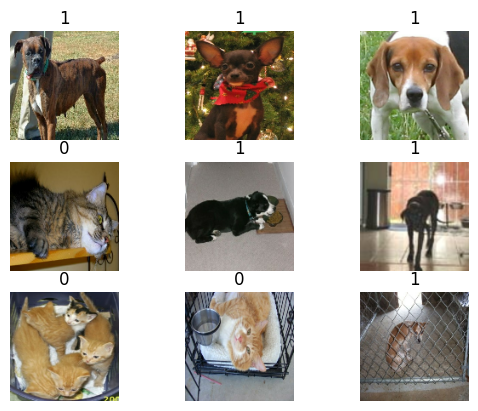

In [8]:
# Show some of images with their labels
fig, axes = plt.subplots(3, 3)

for i, (image, label) in enumerate(train_dataset.take(9)):
    row_i = i // 3
    col_i = i % 3
    axes[row_i, col_i].imshow(image)
    axes[row_i, col_i].axis('off')  # Remove axes
    axes[row_i, col_i].set_title(int(label))  # Set title

plt.show()

In [9]:
# Split the test dataset into validation and test datasets
validation_dataset = test_dataset.take(VALIDATION_SIZE)
test_dataset = test_dataset.skip(VALIDATION_SIZE)

In [10]:
# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
# Building the model
model = Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 29, 29, 64)        0         
 g2D)                                                   

In [13]:
# Defining callbacks
callbacks = [
    # Save the best model at the end with respect to val_loss
    keras.callbacks.ModelCheckpoint(filepath="best_model.keras", monitor='val_loss', save_best_only=True, save_weights_only=True),
    # Stop training if model's accuracy goes bad on val_loss for 3 consecutive epochs
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3),
]

In [14]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [15]:
# Train the model
history = model.fit(train_dataset,
                    epochs=EPOCH_SIZE,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/20
582/582 [==============================] - 51s 71ms/step - loss: 0.6801 - accuracy: 0.5447 - val_loss: 0.6407 - val_accuracy: 0.6217
Epoch 2/20
582/582 [==============================] - 30s 49ms/step - loss: 0.6325 - accuracy: 0.6370 - val_loss: 0.6005 - val_accuracy: 0.6724
Epoch 3/20
582/582 [==============================] - 31s 51ms/step - loss: 0.5963 - accuracy: 0.6817 - val_loss: 0.5835 - val_accuracy: 0.7016
Epoch 4/20
582/582 [==============================] - 31s 52ms/step - loss: 0.5753 - accuracy: 0.7057 - val_loss: 0.5557 - val_accuracy: 0.7171
Epoch 5/20
582/582 [==============================] - 30s 50ms/step - loss: 0.5525 - accuracy: 0.7264 - val_loss: 0.5448 - val_accuracy: 0.7322
Epoch 6/20
582/582 [==============================] - 31s 51ms/step - loss: 0.5382 - accuracy: 0.7339 - val_loss: 0.5390 - val_accuracy: 0.7451
Epoch 7/20
582/582 [==============================] - 31s 49ms/step - loss: 0.5206 - accuracy: 0.7474 - val_loss: 0.5197 - val_accuracy:

In [16]:
# load model and evaluate on test dataset
model.load_weights("best_model.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")

73/73 [==============================] - 8s 64ms/step - loss: 0.2737 - accuracy: 0.8882
Test accuracy: 0.8882201313972473


In [17]:
# Plot the training and validation loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

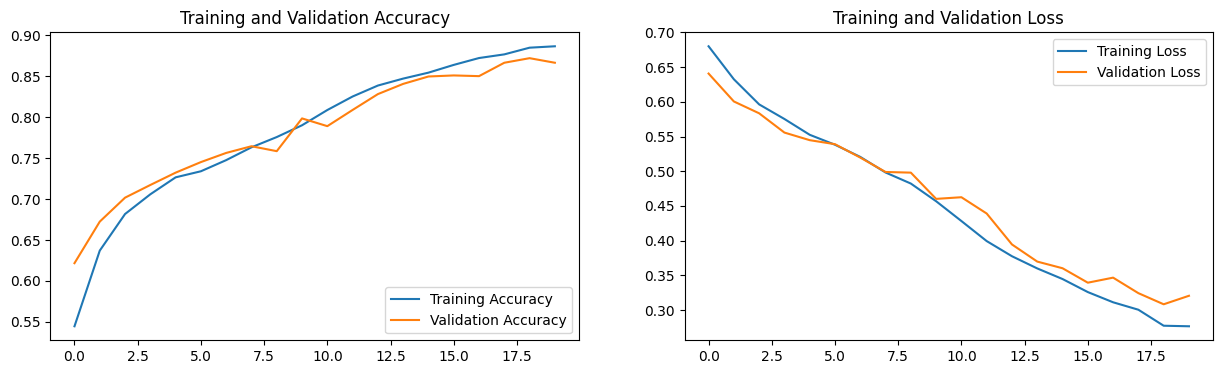

In [18]:
epochs_range = range(EPOCH_SIZE)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()